In [1]:
#Basic libraries
import urllib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime as dt
from matplotlib.ticker import MaxNLocator
import PIL
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')

In [2]:
#Load Data
full_df = pd.read_csv('../road_to_qatar_2022/data/fulldataset.csv')
full_df

,date,home_team,away_team,home_score,away_score,win_conditions,home_team_rank,home_team_points,home_team_previous_points,away_team_rank,away_team_points,away_team_previous_points
0,1930-07-13,France,Mexico,4.0,1.0,,4,1759.78,1764.85,13,1644.89,1649.57
1,1930-07-13,USA,Belgium,3.0,0.0,,16,1627.48,1635.01,2,1816.71,1821.92
2,1930-07-14,Yugoslavia,Brazil,2.0,1.0,,6,64.00,64.00,1,1841.30,1837.56
3,1930-07-14,Romania,Peru,3.0,1.0,,53,1434.68,1427.84,23,1561.01,1562.24
4,1930-07-15,Argentina,France,1.0,0.0,,3,1773.88,1770.65,4,1759.78,1764.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1026,2022-02-05,Cameroon,Burkina Faso,3.0,3.0,Cameroon,43,1471.44,1484.95,54,1432.25,1425.64
1027,2022-02-06,Senegal,Egypt,0.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63
1028,2022-03-29,Senegal,Egypt,1.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63
1029,2022-06-13,Australia,Peru,0.0,0.0,Australia,38,1488.72,1483.73,23,1561.01,1562.24


In [3]:
#ADD winner column on dataset 
winner = []
for i in range (len(full_df['home_team'])):
    if full_df ['home_score'][i] > full_df['away_score'][i]:
        winner.append('win')
    elif full_df['home_score'][i] < full_df ['away_score'][i]:
        winner.append('lose')
    else:
        winner.append('Draw')
full_df['home_team_result'] = winner

In [4]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'win_conditions', 'home_team_rank', 'home_team_points',
       'home_team_previous_points', 'away_team_rank', 'away_team_points',
       'away_team_previous_points', 'home_team_result'],
      dtype='object')

# Small Analysis

In [5]:
fifa_rank = full_df[['date','home_team','away_team','home_team_rank', 'away_team_rank']]
home = fifa_rank[['date','home_team','home_team_rank']].rename(columns={"home_team":"team","home_team_rank":"rank"})
away = fifa_rank[['date','away_team','away_team_rank']].rename(columns={"away_team":"team","away_team_rank":"rank"})
fifa_rank = pd.concat([home,away])
#Select each country latest match
fifa_rank = fifa_rank.sort_values(['team','date'],ascending=[True,False])
fifa_rank_top10 = fifa_rank.groupby('team').first().sort_values('rank',ascending=True)[0:11].reset_index()
fifa_rank_top10 = fifa_rank_top10[fifa_rank_top10.team != 'Yugoslavia']#remove this team as his rank is 6, it's unrealistic

In [6]:
fifa_rank_top10 = fifa_rank_top10.drop(['date'],axis=1)

In [7]:
fifa_rank_top10

,team,rank
0,Brazil,1
1,Belgium,2
2,Argentina,3
3,France,4
4,England,5
6,Italy,6
7,Spain,7
8,Netherlands,8
9,Portugal,9
10,Denmark,10


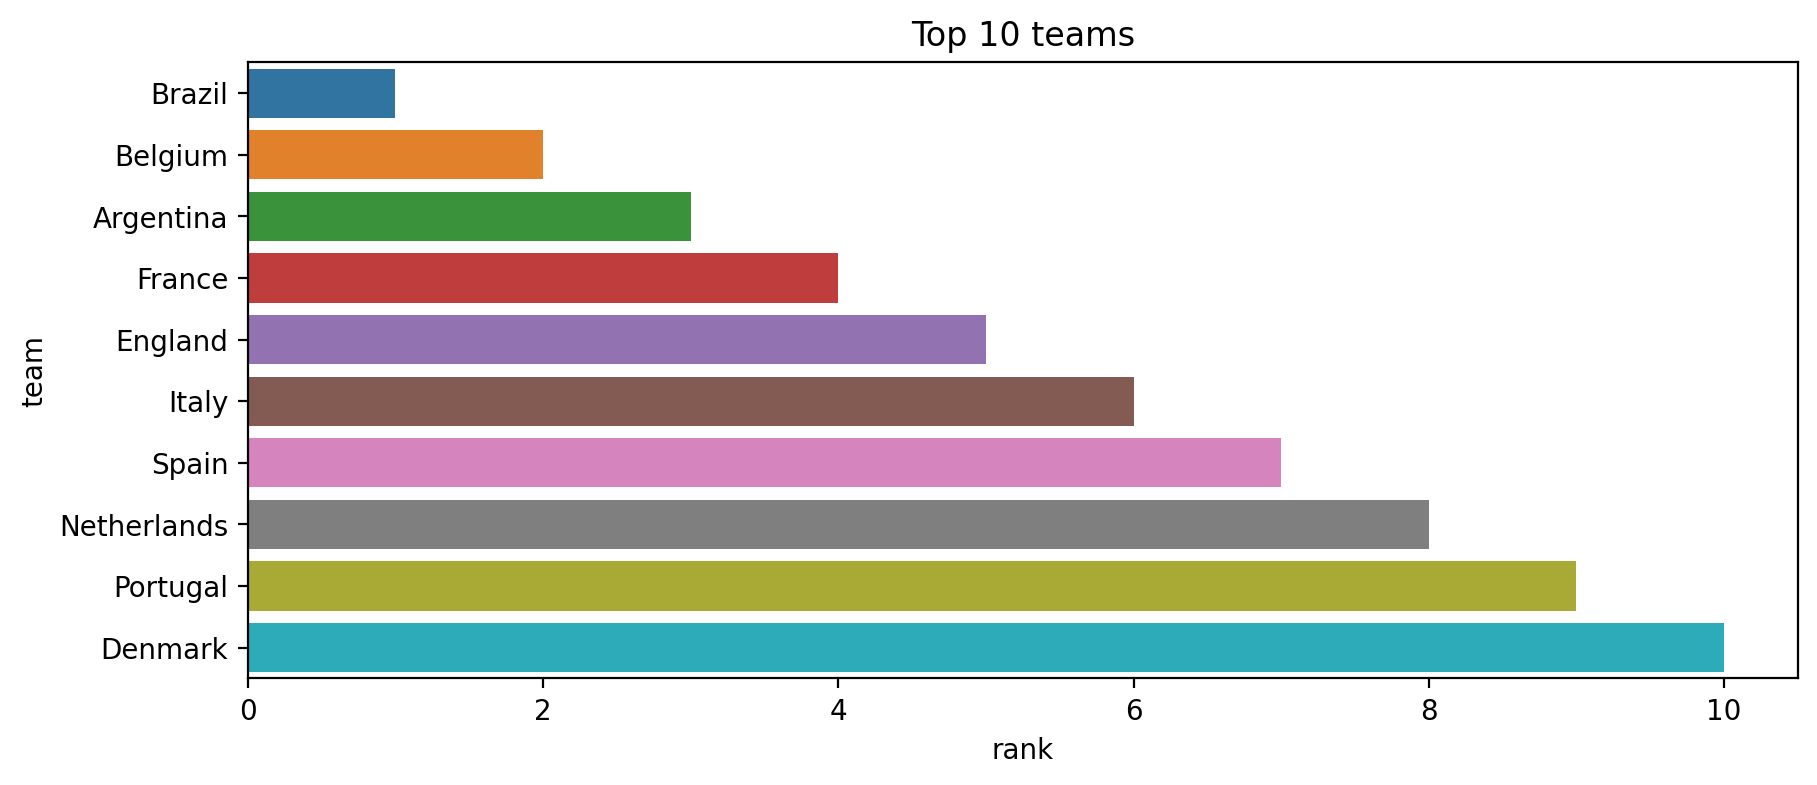

In [8]:
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(data=fifa_rank_top10,y='team',x='rank')
plt.title("Top 10 teams");

In [9]:
#function calculating average win
def home_percentage(team):
    score = len(full_df[(full_df['home_team'] == team) & (full_df['home_team_result'] == "win")]) / len(full_df[full_df['home_team'] == team]) * 100
    return round(score)
def away_percentage(team):
    score = len(full_df[(full_df['away_team'] == team) & (full_df['home_team_result'] == "lose")]) / len(full_df[full_df['away_team'] == team]) * 100
    return round(score)

In [10]:
#add column average win
fifa_rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Average_win_Per'] = round((fifa_rank_top10['Home_win_Per'] + fifa_rank_top10['Away_win_Per'])/2)
fifa_rank_win = fifa_rank_top10.sort_values('Average_win_Per',ascending=False)
fifa_rank_win

,team,rank,Home_win_Per,Away_win_Per,Average_win_Per
0,Brazil,1,67,39,53.0
8,Netherlands,8,53,42,48.0
6,Italy,6,66,22,44.0
7,Spain,7,50,37,44.0
3,France,4,54,31,42.0
2,Argentina,3,67,9,38.0
1,Belgium,2,58,16,37.0
9,Portugal,9,63,9,36.0
10,Denmark,10,33,38,36.0
4,England,5,56,13,34.0


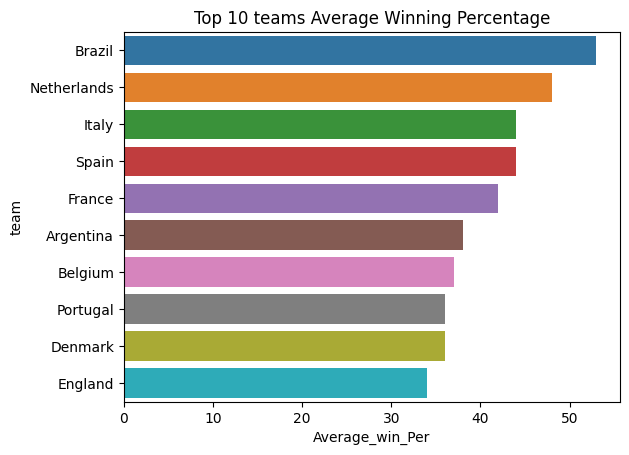

In [11]:
#data viz for top 10 teams
sns.barplot(data=fifa_rank_win,x='Average_win_Per',y='team')
plt.title("Top 10 teams Average Winning Percentage");

In [12]:
full_df.tail()

,date,home_team,away_team,home_score,away_score,win_conditions,home_team_rank,home_team_points,home_team_previous_points,away_team_rank,away_team_points,away_team_previous_points,home_team_result
1026,2022-02-05,Cameroon,Burkina Faso,3.0,3.0,Cameroon,43,1471.44,1484.95,54,1432.25,1425.64,Draw
1027,2022-02-06,Senegal,Egypt,0.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63,Draw
1028,2022-03-29,Senegal,Egypt,1.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63,win
1029,2022-06-13,Australia,Peru,0.0,0.0,Australia,38,1488.72,1483.73,23,1561.01,1562.24,Draw
1030,2022-06-14,Chile,Ghana,0.0,0.0,Ghana,29,1509.61,1514.86,61,1393.00,1393.47,Draw


In [23]:
#Filter the teams participating in World cup 22
list_2022 = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 'IR Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 'Cameroon', 'USA', 'Mexico', 'Wales', 'Australia', 'Costa Rica']
final_df = full_df[(full_df["home_team"].apply(lambda x: x in list_2022)) | (full_df["away_team"].apply(lambda x: x in list_2022))]


In [24]:
#filter latest ranking 
rank = final_df[['date','home_team','away_team','home_team_rank', 'away_team_rank']]
home = rank[['date','home_team','home_team_rank']].rename(columns={"home_team":"team","home_team_rank":"rank"})
away = rank[['date','away_team','away_team_rank']].rename(columns={"away_team":"team","away_team_rank":"rank"})
rank = pd.concat([home,away])
#Select each country latest match
rank = rank.sort_values(['team','date'],ascending=[True,False])
rank_top10 = rank.groupby('team').first().sort_values('rank',ascending=True).reset_index()
rank_top10 = rank_top10[(rank_top10["team"].apply(lambda x: x in list_2022))][0:10]
#rank_top10.drop(['date'],axis=1)

In [25]:
#updated average win
rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(rank_top10['team'])
rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(rank_top10['team'])
rank_top10['Average_win_Per'] = round((rank_top10['Home_win_Per'] + rank_top10['Away_win_Per'])/2)
rank_top10_Win = rank_top10.sort_values('Average_win_Per',ascending=False)
rank_top10_Win


,team,date,rank,Home_win_Per,Away_win_Per,Average_win_Per
11,Germany,2016-07-02,11,67,49,58.0
0,Brazil,2019-06-27,1,67,39,53.0
8,Netherlands,2014-07-12,8,53,42,48.0
7,Spain,2021-07-06,7,50,37,44.0
3,France,2021-06-28,4,54,31,42.0
2,Argentina,2021-07-06,3,67,9,38.0
1,Belgium,2014-07-05,2,58,16,37.0
9,Portugal,2017-06-28,9,63,9,36.0
10,Denmark,2018-07-01,10,33,38,36.0
4,England,2021-07-11,5,56,13,34.0


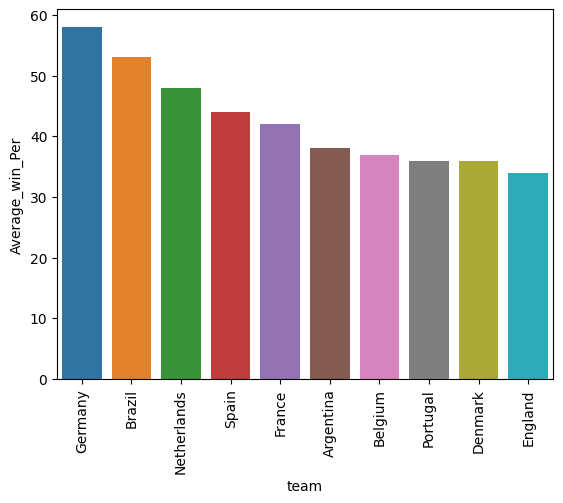

In [26]:
#data viz for average win
sns.barplot(data=rank_top10_Win,x='team',y='Average_win_Per')
plt.xticks(rotation=90);

# Dataset preparation

## Make dataset for preliminary

In [27]:
#Mapping numeric values for home_team_result to find the correleations
#win = 1
#Draw = 2
#lose = 0
final_df['home_team_result'] = final_df['home_team_result'].map({'win':1, 'Draw':2, 'lose':0})

/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_71897/2298783881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['home_team_result'] = final_df['home_team_result'].map({'win':1, 'Draw':2, 'lose':0})


In [28]:
final_df.corr()['home_team_result'].sort_values(ascending=False)

/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_71897/4154585168.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_df.corr()['home_team_result'].sort_values(ascending=False)


home_team_result             1.000000
away_team_rank               0.141939
home_team_rank               0.053119
home_team_points             0.002057
home_team_previous_points    0.001444
away_team_points            -0.069523
away_team_previous_points   -0.069665
home_score                  -0.083079
away_score                  -0.385247
Name: home_team_result, dtype: float64

In [29]:
final_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'win_conditions', 'home_team_rank', 'home_team_points',
       'home_team_previous_points', 'away_team_rank', 'away_team_points',
       'away_team_previous_points', 'home_team_result'],
      dtype='object')

In [30]:
final_df =final_df.drop(['date','home_score', 'away_score',
       'win_conditions','home_team_previous_points',
       'away_team_previous_points'], axis=1)

In [31]:
# Change column names
final_df.rename(columns={
                         "home_team":"Team1", "away_team":"Team2", 
                         "home_team_rank":"Team1_FIFA_RANK", 
                         "away_team_rank":"Team2_FIFA_RANK",
                         "home_team_points":"Team1_points",
                         "away_team_points":"Team2_points",
                         "home_team_result":"Team1_Result"
                        }, 
                inplace=True
               )

In [32]:
final_df

,Team1,Team2,Team1_FIFA_RANK,Team1_points,Team2_FIFA_RANK,Team2_points,Team1_Result
0,France,Mexico,4,1759.78,13,1644.89,1
1,USA,Belgium,16,1627.48,2,1816.71,1
2,Yugoslavia,Brazil,6,64.00,1,1841.30,1
4,Argentina,France,3,1773.88,4,1759.78,1
5,Chile,Mexico,29,1509.61,13,1644.89,1
...,...,...,...,...,...,...,...
1026,Cameroon,Burkina Faso,43,1471.44,54,1432.25,2
1027,Senegal,Egypt,18,1584.38,39,1486.44,2
1028,Senegal,Egypt,18,1584.38,39,1486.44,1
1029,Australia,Peru,38,1488.72,23,1561.01,2


/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_71897/1269800436.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final_df.corr(),annot=True)


<AxesSubplot: >

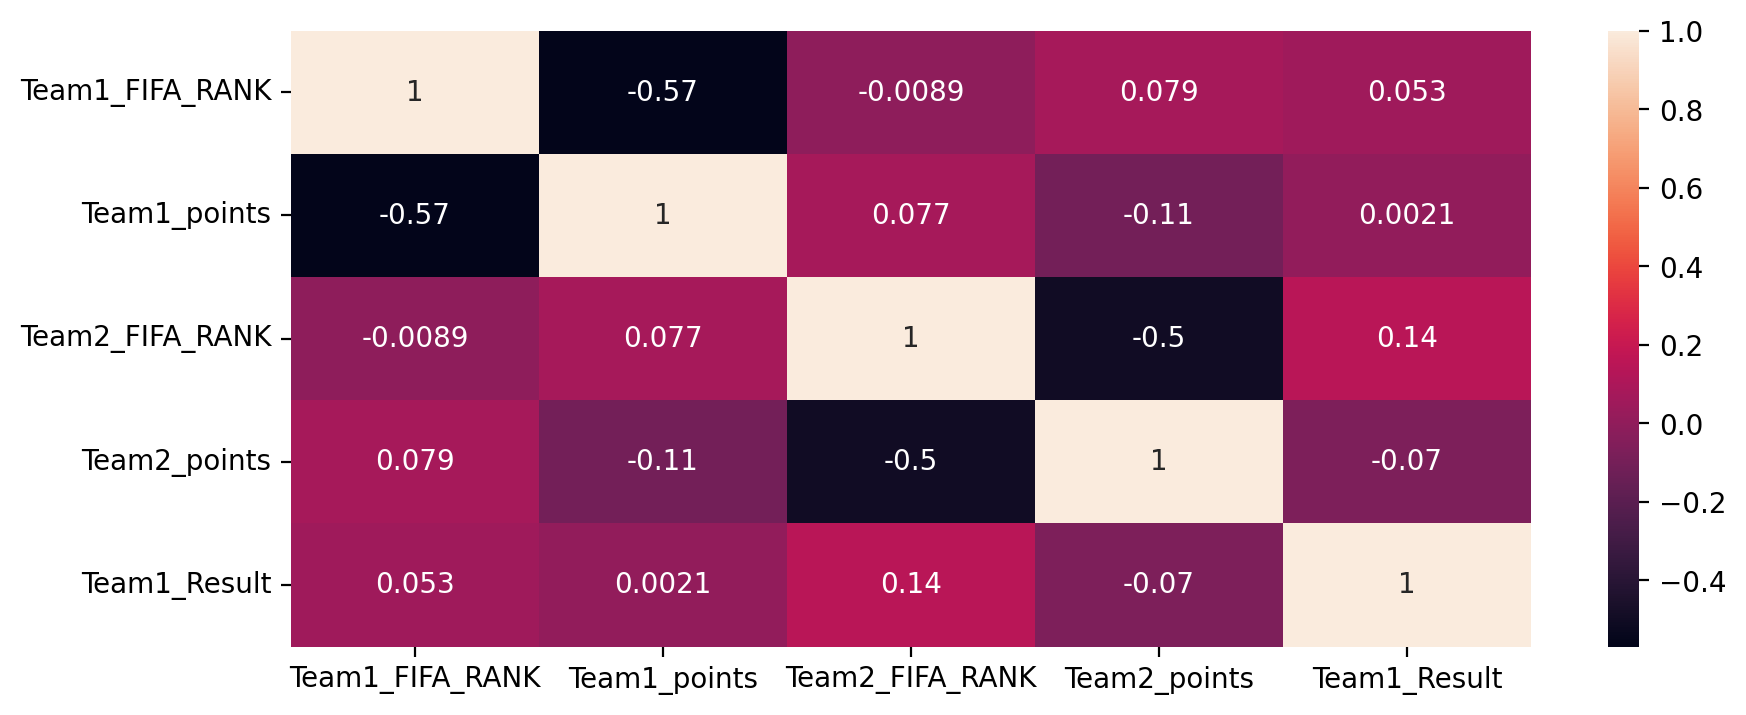

In [33]:
plt.figure(figsize=(10,4),dpi=200)
sns.heatmap(final_df.corr(),annot=True)

In [34]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 1030
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Team1            884 non-null    object 
 1   Team2            884 non-null    object 
 2   Team1_FIFA_RANK  884 non-null    int64  
 3   Team1_points     884 non-null    float64
 4   Team2_FIFA_RANK  884 non-null    int64  
 5   Team2_points     884 non-null    float64
 6   Team1_Result     884 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 55.2+ KB


In [35]:
#Holdout another DF for pipeline
pipe_DF = final_df
#Create dummies for categorical columns
final_df = pd.get_dummies(final_df)

## Make dataset for knockout round

In [36]:
full_df = full_df.copy()
full_df.head()

,date,home_team,away_team,home_score,away_score,win_conditions,home_team_rank,home_team_points,home_team_previous_points,away_team_rank,away_team_points,away_team_previous_points,home_team_result
0,1930-07-13,France,Mexico,4.0,1.0,,4,1759.78,1764.85,13,1644.89,1649.57,win
1,1930-07-13,USA,Belgium,3.0,0.0,,16,1627.48,1635.01,2,1816.71,1821.92,win
2,1930-07-14,Yugoslavia,Brazil,2.0,1.0,,6,64.00,64.00,1,1841.30,1837.56,win
3,1930-07-14,Romania,Peru,3.0,1.0,,53,1434.68,1427.84,23,1561.01,1562.24,win
4,1930-07-15,Argentina,France,1.0,0.0,,3,1773.88,1770.65,4,1759.78,1764.85,win


In [37]:
#change draw result to win depending on win conditions
full_df['knockout_result'] = np.where((full_df['home_team_result'] == 'Draw') & 
                                      (full_df['win_conditions']  == 
                                     full_df['home_team']), 'win',
                                      full_df['home_team_result'])

In [38]:
#change draw result to lose depending on win conditions
full_df['knockout_result'] = np.where((full_df['knockout_result'] == 'Draw'), 'lose',
                                      full_df['knockout_result'])

In [39]:
#filter teams qualified for world cup 2022
final_knockout_df = full_df[(full_df["home_team"].apply(lambda x: x in list_2022)) | 
                            (full_df["away_team"].apply(lambda x: x in list_2022))]

In [40]:
#change win, lose into numerical
final_knockout_df['knockout_result'] = final_knockout_df['knockout_result'].map({'win':1, 'lose':0})

/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_71897/2304044233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_knockout_df['knockout_result'] = final_knockout_df['knockout_result'].map({'win':1, 'lose':0})


In [41]:
#drop unecessary column for knockout dataset 
final_knockout_df = final_knockout_df.drop(['date','home_score', 'away_score',
       'win_conditions','home_team_previous_points',
       'away_team_previous_points','home_team_result'], axis=1)

In [42]:
final_knockout_df.tail()

,home_team,away_team,home_team_rank,home_team_points,away_team_rank,away_team_points,knockout_result
1026,Cameroon,Burkina Faso,43,1471.44,54,1432.25,1
1027,Senegal,Egypt,18,1584.38,39,1486.44,1
1028,Senegal,Egypt,18,1584.38,39,1486.44,1
1029,Australia,Peru,38,1488.72,23,1561.01,1
1030,Chile,Ghana,29,1509.61,61,1393.00,0


In [43]:
#change column name
final_knockout_df.rename(columns={
                         "home_team":"Team1", "away_team":"Team2", 
                         "home_team_rank":"Team1_FIFA_RANK", 
                         "away_team_rank":"Team2_FIFA_RANK",
                         "home_team_points":"Team1_points",
                         "away_team_points":"Team2_points",
                         "knockout_result":"Team1_Result"
                        }, 
                inplace=True
               )

In [44]:
final_knockout_df.tail()

,Team1,Team2,Team1_FIFA_RANK,Team1_points,Team2_FIFA_RANK,Team2_points,Team1_Result
1026,Cameroon,Burkina Faso,43,1471.44,54,1432.25,1
1027,Senegal,Egypt,18,1584.38,39,1486.44,1
1028,Senegal,Egypt,18,1584.38,39,1486.44,1
1029,Australia,Peru,38,1488.72,23,1561.01,1
1030,Chile,Ghana,29,1509.61,61,1393.00,0


/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_71897/1941211883.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final_knockout_df.corr(), annot=True)


<AxesSubplot: >

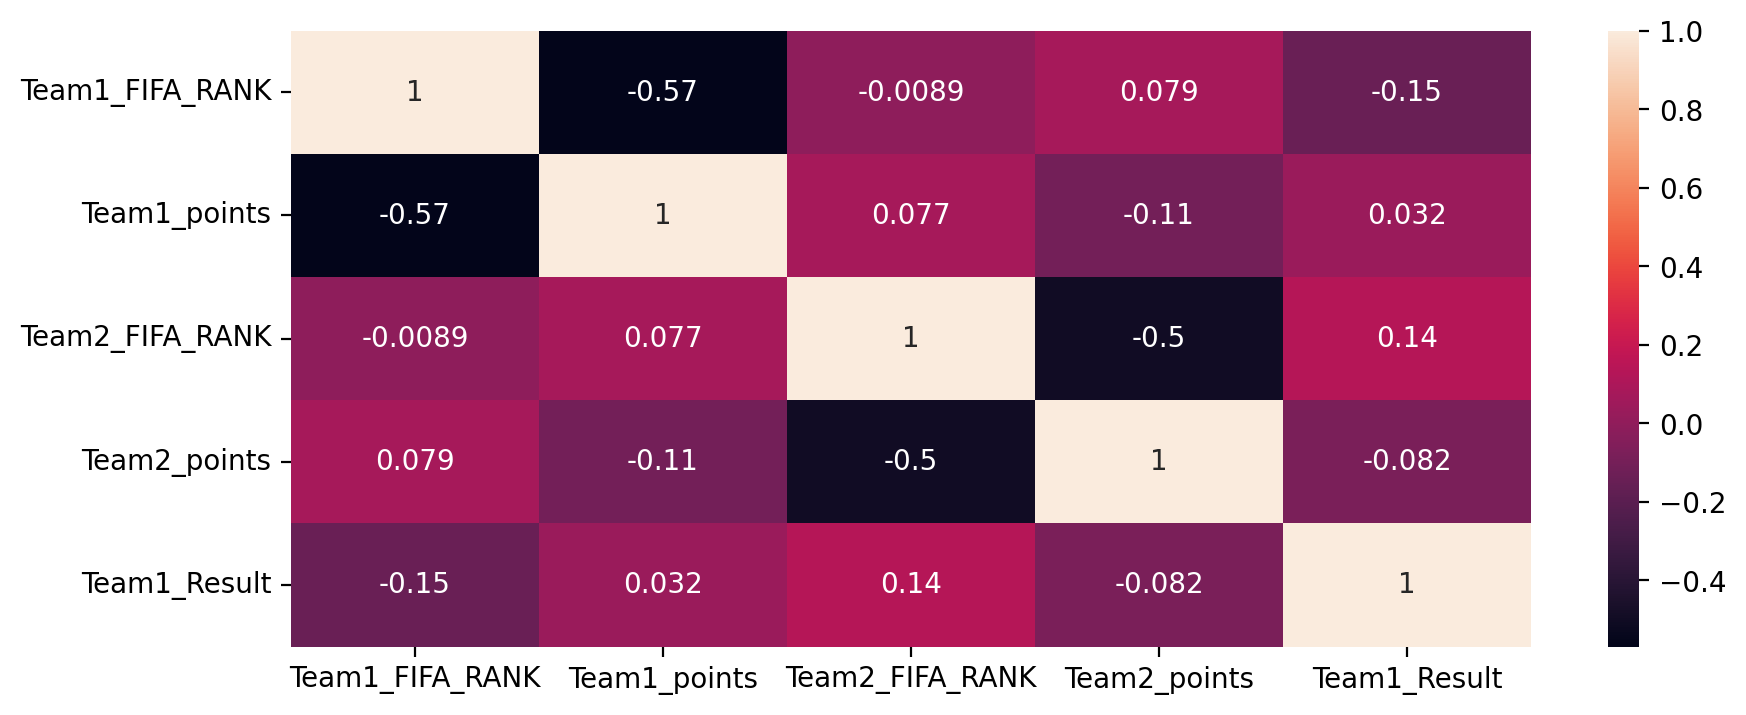

In [45]:
plt.figure(figsize=(10, 4), dpi=200)
sns.heatmap(final_knockout_df.corr(), annot=True)

In [46]:
#Knockout Round
#Holdout another DF for pipeline
pipe_DF_knockout = final_knockout_df
#Create dummies for categorical columns
knockout_final_df = pd.get_dummies(final_knockout_df)

# Prediction models for preliminary round - W,D,L

In [47]:
#split X and y and train test split (For League Matches)
X = final_df.drop('Team1_Result',axis=1)
y = final_df['Team1_Result']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
#Validtion and test set
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [48]:
#Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_hold_test = scaler.transform(X_hold_test)


In [49]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
#function to fit different model and vizualize them
def metrics_display(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

- Decision Tree 

              precision    recall  f1-score   support

           0       0.48      0.38      0.42        29
           1       0.56      0.67      0.61        58
           2       0.42      0.37      0.40        46

    accuracy                           0.50       133
   macro avg       0.49      0.47      0.48       133
weighted avg       0.49      0.50      0.49       133



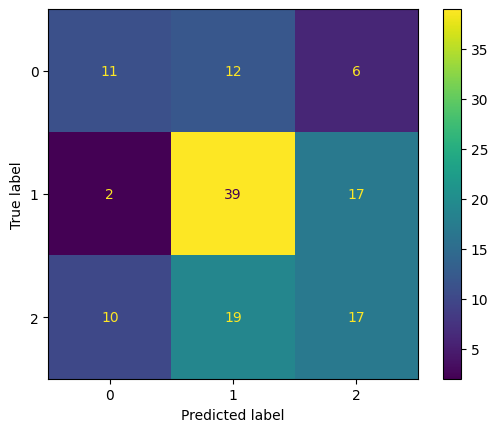

In [50]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
metrics_display(DecisionTreeClassifier())

 - Random Forest

              precision    recall  f1-score   support

           0       0.44      0.24      0.31        29
           1       0.52      0.66      0.58        58
           2       0.43      0.41      0.42        46

    accuracy                           0.48       133
   macro avg       0.46      0.44      0.44       133
weighted avg       0.47      0.48      0.47       133



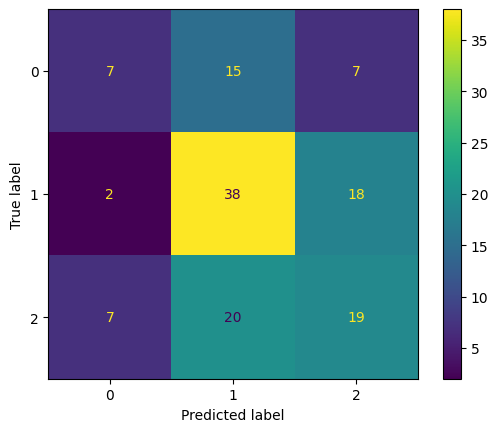

In [51]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier
metrics_display(RandomForestClassifier())

 - Ada Boost

              precision    recall  f1-score   support

           0       0.33      0.17      0.23        29
           1       0.51      0.66      0.58        58
           2       0.43      0.41      0.42        46

    accuracy                           0.47       133
   macro avg       0.43      0.41      0.41       133
weighted avg       0.45      0.47      0.45       133



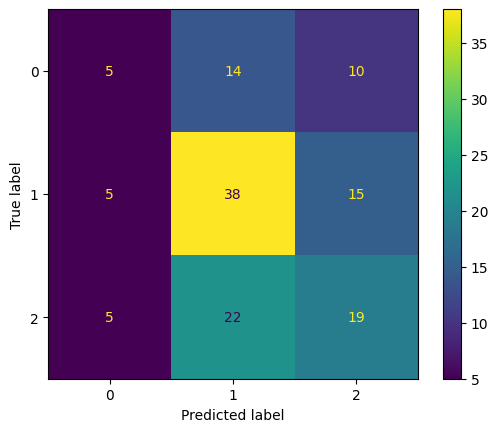

In [52]:
#Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier
metrics_display(AdaBoostClassifier())


- Gaussian Classifier

              precision    recall  f1-score   support

           0       0.50      0.24      0.33        29
           1       0.56      0.69      0.62        58
           2       0.42      0.43      0.43        46

    accuracy                           0.50       133
   macro avg       0.49      0.46      0.46       133
weighted avg       0.50      0.50      0.49       133



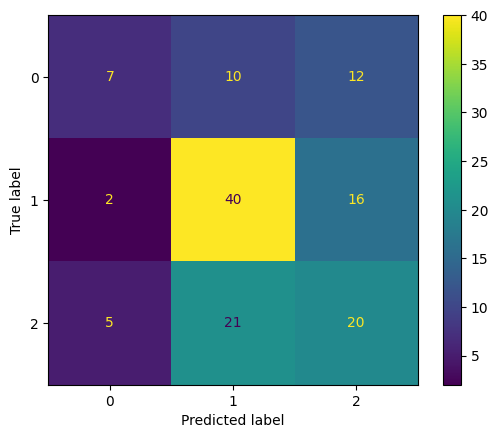

In [53]:
#GaussianProcess Classifier 
from sklearn.gaussian_process import GaussianProcessClassifier
metrics_display(GaussianProcessClassifier())

 - KNN 

              precision    recall  f1-score   support

           0       0.36      0.28      0.31        29
           1       0.45      0.67      0.54        58
           2       0.29      0.15      0.20        46

    accuracy                           0.41       133
   macro avg       0.37      0.37      0.35       133
weighted avg       0.38      0.41      0.37       133



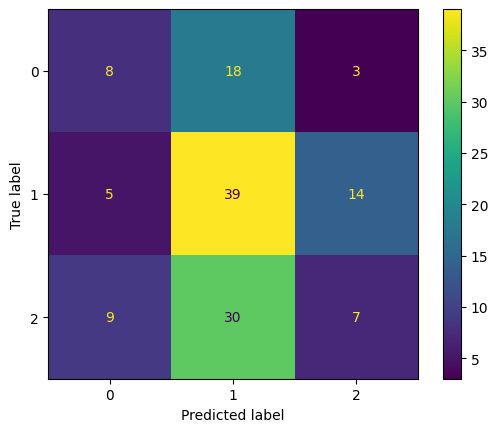

In [54]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier 
metrics_display(KNeighborsClassifier())

 - XGB Boost

/Users/prashaantgaju/.pyenv/versions/3.8.12/envs/RoadToQatar2022/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.50      0.21      0.29        29
           1       0.49      0.64      0.55        58
           2       0.42      0.41      0.42        46

    accuracy                           0.47       133
   macro avg       0.47      0.42      0.42       133
weighted avg       0.47      0.47      0.45       133



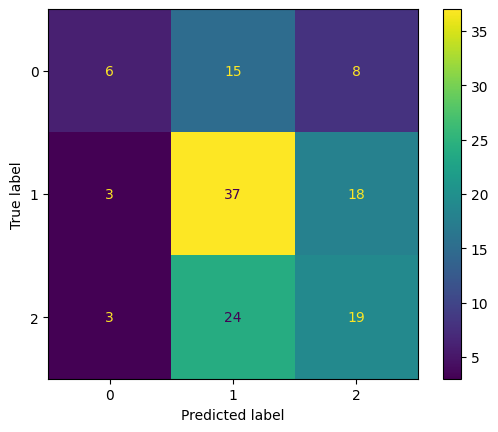

In [55]:
#XGB Boost
from xgboost import XGBClassifier
metrics_display(XGBClassifier(use_label_encoder=False))

In [56]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = XGBClassifier(random_state=123)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))



print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.75      0.82       103
           1       0.84      0.97      0.90       292
           2       0.91

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Make a dictionary of hyperparameter values to search
search_space = {
    "n_estimators" : [200,250,300,350,400,450,500],
    "max_depth" : [3,4,5],
    "gamma" : [0.001,0.01,0.1],
    "learning_rate" : [0.001,0.01,0.1]
}

In [ ]:
GS = GridSearchCV(estimator = XGBClassifier(use_label_encoder=False),
                  param_grid = search_space,
                  scoring = 'accuracy',
                  cv = 5,
                  verbose = 4)

In [58]:
GS.fit(X_train,y_train)

NameError: name 'GS' is not defined

In [ ]:
print(GS.best_params_) # to get only the best hyperparameter values that w

 - Default hyperparameters

              precision    recall  f1-score   support

           0       0.47      0.36      0.41        22
           1       0.54      0.58      0.56        67
           2       0.43      0.43      0.43        44

    accuracy                           0.50       133
   macro avg       0.48      0.46      0.47       133
weighted avg       0.49      0.50      0.49       133



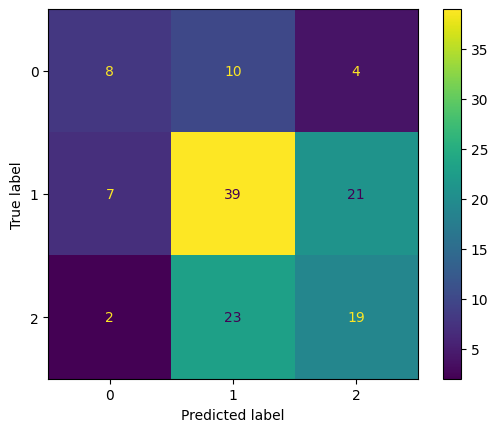

In [59]:
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

- Tuned Hyperparameters

/Users/prashaantgaju/.pyenv/versions/3.8.12/envs/RoadToQatar2022/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.80      0.36      0.50        22
           1       0.59      0.70      0.64        67
           2       0.51      0.50      0.51        44

    accuracy                           0.58       133
   macro avg       0.63      0.52      0.55       133
weighted avg       0.60      0.58      0.57       133



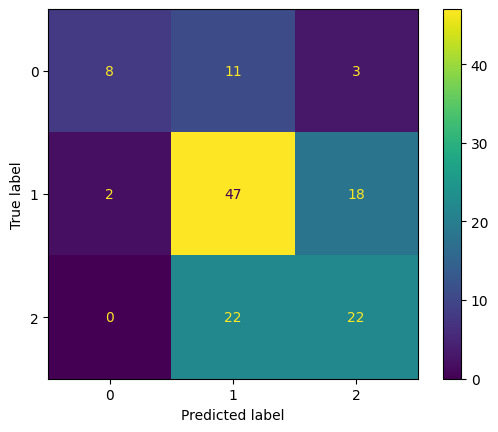

In [60]:
model = XGBClassifier(use_label_encoder = False, gamma = 0.001, learning_rate = 0.01, n_estimators = 400, max_depth = 5)
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

- Neural Net

In [61]:
X_train.shape

(618, 180)

In [ ]:
#simple Neural network
#p.s : can't run it on my machine because of the tensorflow package conflicts with M1, try to run and see the results
import keras
from keras import Sequential
from keras.layers import Dense,Dropout
from keras import Input

model = Sequential()
model.add(Input(shape=(180,)))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=10,validation_split=0.2)

y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1,axis=1)
print(classification_report(y_test,y_pred1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred1)

- Group Stage Final Pipeline

In [62]:
#XBBoost Model is finalised, so creating a pipeline for the prelim
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(),['Team1', 'Team2']),remainder='passthrough')

pipe_X = pipe_DF.drop('Team1_Result',axis=1)
pipe_y = pipe_DF['Team1_Result']

from sklearn.pipeline import make_pipeline
pipe_League = make_pipeline(column_trans,StandardScaler(with_mean=False),XGBClassifier(use_label_encoder=False, gamma= 0.001, learning_rate= 0.01, n_estimators= 400, max_depth= 5))
pipe_League.fit(pipe_X,pipe_y)

/Users/prashaantgaju/.pyenv/versions/3.8.12/envs/RoadToQatar2022/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Team1', 'Team2'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_...
                               feature_types=None, gamma=0.001, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.01,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=400, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto', ...))])

In [63]:
import pickle
# save the model to disk
#filename = 'preli_finalized_model.pkl'
#pickle.dump(model, open(filename, 'wb'))

In [64]:
# look fixtures of world cup 2022 in the path in your machine

group_fix = pd.read_csv('../raw_data/fix_group.csv')
only_group = group_fix.head(48)#filtering only fixtures schedule

In [65]:
only_group = only_group.drop(['Match Number','Round Number','Date','Location','Result'],axis=1)


In [66]:
only_group

,Home Team,Away Team,Group
0,Qatar,Ecuador,Group A
1,England,Iran,Group B
2,Senegal,Netherlands,Group A
3,USA,Wales,Group B
4,Argentina,Saudi Arabia,Group C
5,Denmark,Tunisia,Group D
6,Mexico,Poland,Group C
7,France,Australia,Group D
8,Morocco,Croatia,Group F
9,Germany,Japan,Group E


In [67]:
only_group['groups'] = only_group['Group'].str.extract(r'\b(\w+)$', expand=True)

In [68]:
to_keep =only_group.sort_values('groups').copy()

In [69]:
to_use_to_pred = only_group.sort_values('groups').copy()
to_use_to_pred.rename(columns={"Home Team":"home_team",
                              "Away Team":"away_team"}, inplace=True)


to_use_to_pred


,home_team,away_team,Group,groups
0,Qatar,Ecuador,Group A,A
2,Senegal,Netherlands,Group A,A
33,Netherlands,Qatar,Group A,A
32,Ecuador,Senegal,Group A,A
18,Netherlands,Ecuador,Group A,A
17,Qatar,Senegal,Group A,A
1,England,Iran,Group B,B
3,USA,Wales,Group B,B
35,Iran,USA,Group B,B
34,Wales,England,Group B,B


In [70]:
ranking_df = pd.read_csv('../road_to_qatar_2022/data/fulldataset.csv')
ranking_df = ranking_df.drop(['date','home_score','away_score',
                              'win_conditions',
                              'home_team_previous_points',
                              'away_team_previous_points'],
                            axis=1)

In [73]:
ranking_df 

,home_team,away_team,home_team_rank,home_team_points,away_team_rank,away_team_points
0,France,Mexico,4,1759.78,13,1644.89
1,USA,Belgium,16,1627.48,2,1816.71
2,Yugoslavia,Brazil,6,64.00,1,1841.30
3,Romania,Peru,53,1434.68,23,1561.01
4,Argentina,France,3,1773.88,4,1759.78
...,...,...,...,...,...,...
1026,Cameroon,Burkina Faso,43,1471.44,54,1432.25
1027,Senegal,Egypt,18,1584.38,39,1486.44
1028,Senegal,Egypt,18,1584.38,39,1486.44
1029,Australia,Peru,38,1488.72,23,1561.01


In [74]:
pd.merge(to_use_to_pred,
        ranking_df,
        how='left',
        left_on=['home_team','away_team'],
        right_on=['home_team','away_team'])

,home_team,away_team,Group,groups,home_team_rank,home_team_points,away_team_rank,away_team_points
0,Qatar,Ecuador,Group A,A,NaN,NaN,NaN,NaN
1,Senegal,Netherlands,Group A,A,NaN,NaN,NaN,NaN
2,Netherlands,Qatar,Group A,A,NaN,NaN,NaN,NaN
3,Ecuador,Senegal,Group A,A,NaN,NaN,NaN,NaN
4,Netherlands,Ecuador,Group A,A,NaN,NaN,NaN,NaN
5,Qatar,Senegal,Group A,A,NaN,NaN,NaN,NaN
6,England,Iran,Group B,B,NaN,NaN,NaN,NaN
7,USA,Wales,Group B,B,NaN,NaN,NaN,NaN
8,Iran,USA,Group B,B,NaN,NaN,NaN,NaN
9,Wales,England,Group B,B,NaN,NaN,NaN,NaN


# Prediction for Knockout Stage 

In [75]:
final_knockout_df

,Team1,Team2,Team1_FIFA_RANK,Team1_points,Team2_FIFA_RANK,Team2_points,Team1_Result
0,France,Mexico,4,1759.78,13,1644.89,1
1,USA,Belgium,16,1627.48,2,1816.71,1
2,Yugoslavia,Brazil,6,64.00,1,1841.30,1
4,Argentina,France,3,1773.88,4,1759.78,1
5,Chile,Mexico,29,1509.61,13,1644.89,1
...,...,...,...,...,...,...,...
1026,Cameroon,Burkina Faso,43,1471.44,54,1432.25,1
1027,Senegal,Egypt,18,1584.38,39,1486.44,1
1028,Senegal,Egypt,18,1584.38,39,1486.44,1
1029,Australia,Peru,38,1488.72,23,1561.01,1


In [76]:
final_knockout_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 1030
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Team1            884 non-null    object 
 1   Team2            884 non-null    object 
 2   Team1_FIFA_RANK  884 non-null    int64  
 3   Team1_points     884 non-null    float64
 4   Team2_FIFA_RANK  884 non-null    int64  
 5   Team2_points     884 non-null    float64
 6   Team1_Result     884 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 55.2+ KB


In [77]:
#Holdout another DF for pipeline
pipe_DF_knockout = final_knockout_df
#Create dummies for categorical columns
knockout_final_df = pd.get_dummies(final_knockout_df)

In [78]:
X = knockout_final_df.drop('Team1_Result',axis=1)
y = knockout_final_df['Team1_Result']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


- Ada Boost Classifier

              precision    recall  f1-score   support

           0       0.50      0.29      0.37        62
           1       0.55      0.75      0.63        71

    accuracy                           0.53       133
   macro avg       0.52      0.52      0.50       133
weighted avg       0.52      0.53      0.51       133



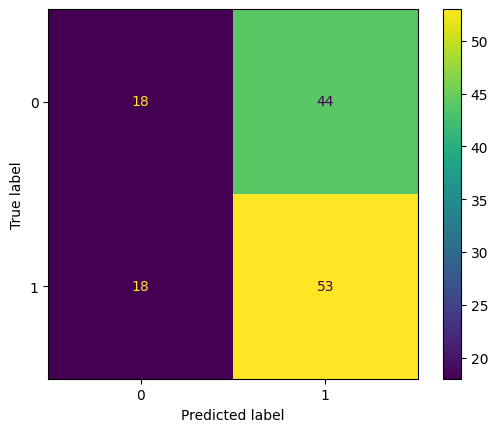

In [79]:
metrics_display(AdaBoostClassifier())


- Random Forest

              precision    recall  f1-score   support

           0       0.42      0.35      0.39        62
           1       0.51      0.58      0.54        71

    accuracy                           0.47       133
   macro avg       0.46      0.47      0.46       133
weighted avg       0.47      0.47      0.47       133



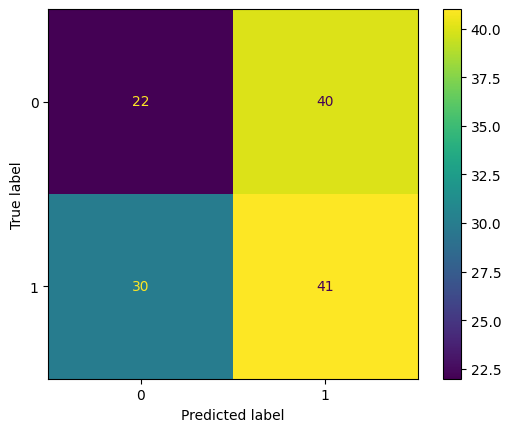

In [80]:
#random classifier on knockout round
metrics_display(RandomForestClassifier())


- XGB Boost

/Users/prashaantgaju/.pyenv/versions/3.8.12/envs/RoadToQatar2022/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.51      0.35      0.42        62
           1       0.56      0.70      0.62        71

    accuracy                           0.54       133
   macro avg       0.53      0.53      0.52       133
weighted avg       0.54      0.54      0.53       133



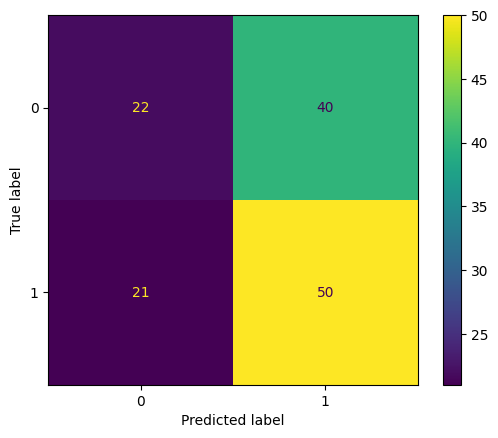

In [81]:
metrics_display(XGBClassifier(use_label_encoder=False))


- Neural Net

In [82]:
X_train.shape


(618, 180)

In [ ]:
model = Sequential()
model.add(Input(shape=(180,)))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=10,validation_split=0.2)

y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1,axis=1)
print(classification_report(y_test,y_pred1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred1)


## Random Forest - Tuning & Hold-out Validation

In [83]:
search_space = {
    "max_depth" : [11,12,13,14,15,16],
    "max_leaf_nodes" : [170,180,190,200,210,220,230],
    "min_samples_leaf" : [3,4,5,6,7,8],
    "n_estimators" : [310,320,330,340,350]
}

In [84]:
GS = GridSearchCV(estimator = RandomForestClassifier(),
                  param_grid = search_space,
                  scoring = 'accuracy',
                  cv = 5,
                  verbose = 4)

In [ ]:

GS.fit(X_train,y_train)

In [ ]:
print(GS.best_params_)


- Default Hyperparameters

              precision    recall  f1-score   support

           0       0.37      0.40      0.38        50
           1       0.62      0.59      0.60        83

    accuracy                           0.52       133
   macro avg       0.50      0.50      0.49       133
weighted avg       0.53      0.52      0.52       133



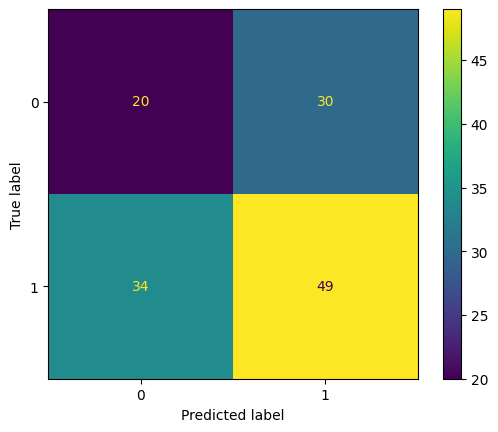

In [85]:
#Random Forest is giving good accuracy, so testing with holdout test and finalising the model
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

- Tuned Hyperparameters

              precision    recall  f1-score   support

           0       0.55      0.32      0.41        50
           1       0.67      0.84      0.75        83

    accuracy                           0.65       133
   macro avg       0.61      0.58      0.58       133
weighted avg       0.63      0.65      0.62       133



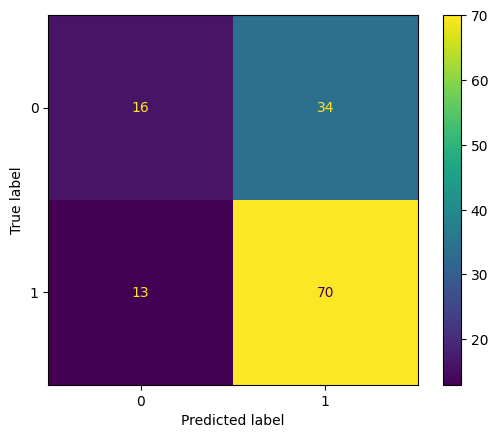

In [86]:
model = RandomForestClassifier(max_depth= 11, n_estimators=320, max_leaf_nodes= 170, min_samples_leaf= 5)
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);


In [87]:
#Building pipeline for knockout round
pipe_X = pipe_DF_knockout.drop('Team1_Result',axis=1)
pipe_y = pipe_DF_knockout['Team1_Result']
column_trans = make_column_transformer(
    (OneHotEncoder(),['Team1', 'Team2']),remainder='passthrough')
pipe_knock = make_pipeline(column_trans,StandardScaler(with_mean=False),RandomForestClassifier(max_depth= 11, n_estimators=320, max_leaf_nodes= 170, min_samples_leaf= 5))
pipe_knock.fit(pipe_X,pipe_y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Team1', 'Team2'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=11, max_leaf_nodes=170,
                                        min_samples_leaf=5,
                                        n_estimators=320))])

In [ ]:
import pickle
# save the model to disk
#filename = 'knock_finalized_model.pkl'
#pickle.dump(model, open(filename, 'wb'))